# Airbnb Berlin: a short analysis on pricing and superhosts

## Used libraries and settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, RandomForestRegressor

# increase width of notebook to work with large datasets
from IPython.core.display import HTML
display(HTML("<style>.container { width:65% !important; }</style>"))
pd.set_option('display.max_columns', None)

## 01. Business Understanding

The given Airbnb dataset has many features to analyse, and thus a large amount of questions one could think of when looking at the data. So just some of the possible questions should be analyzed in this notebook:

#### Chosen questions to answer:

1. How do superhosts compare to standard hosts?
    - Where do (super-)hosts come from?
    - Are superhosts long term hosts (since 2008)?
    - Do superhosts get better reviews?
    - Are superhosts mostly located near the citycentre?
    - How many listings do superhosts have?
2. How does the listing location influence the price?
3. What factors influence the price?

## 02. Data Understanding 

### Information on used data
The collection of datasets was downloaded from http://insideairbnb.com/get-the-data.html on 20th of march 2021 (data compile date 20th of February 2021):

| filename | file description (insideairbnb.com) |
| :-- | :-- |
| listings.csv | Detailed Review Data for listings in Berlin |
| listings_short.csv | Summary information and metrics for listings in Berlin (good for visualisations) |
| calendar.csv | Detailed Calendar Data for listings in Berlin |
| reviews.csv | Detailed Review Data for listings in Berlin |
| reviews_short.csv | Summary Review data and Listing ID (to facilitate time based analytics and visualisations linked to a listing) |
| neighbourhoods.csv | Neighbourhood list for geo filter. Sourced from city or open source GIS files |
| neighbourhoods.geojson | GeoJSON file of neighbourhoods of the city |

+ The listings dataset seems to be the most interesting, telling a lot about each listing in detail. So this dataset will be further analyzed in this notebook.
+ In the calender dataset there is information on when the listings are available in the next 12 months, including pricing. This will not be analyzed.
+ The review data is also not used, since natural language processing is out of the scope of this analysis.

### First look at the data

In [2]:
# function to make a first look at the dataset a little more comfortable
def firstlook_csv(filename):
    """
    Provide some basic information on the dataset:
    - Size of dataset
    - Column names
    - pd.head(3) of dataset
    INPUT: filename, relative to notebook
    OUTPUT: pd.Dataframe of file
    """
    
    file = pd.read_csv(filename)
    print("Size of data: ", file.shape)
    print("Columns:")
    for col in file.columns:
        print("-", col)
    display(file.head(1))
    
    return file

In [3]:
listings = firstlook_csv("listings.csv")

Size of data:  (19978, 74)
Columns:
- id
- listing_url
- scrape_id
- last_scraped
- name
- description
- neighborhood_overview
- picture_url
- host_id
- host_url
- host_name
- host_since
- host_location
- host_about
- host_response_time
- host_response_rate
- host_acceptance_rate
- host_is_superhost
- host_thumbnail_url
- host_picture_url
- host_neighbourhood
- host_listings_count
- host_total_listings_count
- host_verifications
- host_has_profile_pic
- host_identity_verified
- neighbourhood
- neighbourhood_cleansed
- neighbourhood_group_cleansed
- latitude
- longitude
- property_type
- room_type
- accommodates
- bathrooms
- bathrooms_text
- bedrooms
- beds
- amenities
- price
- minimum_nights
- maximum_nights
- minimum_minimum_nights
- maximum_minimum_nights
- minimum_maximum_nights
- maximum_maximum_nights
- minimum_nights_avg_ntm
- maximum_nights_avg_ntm
- calendar_updated
- has_availability
- availability_30
- availability_60
- availability_90
- availability_365
- calendar_last_scr

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2015,https://www.airbnb.com/rooms/2015,20210220051856,2021-02-21,Berlin-Mitte Value! Quiet courtyard/very central,Great location! <br />30 of 75 sq meters. Thi...,It is located in the former East Berlin area o...,https://a0.muscache.com/pictures/260fd609-710a...,2217,https://www.airbnb.com/users/show/2217,Ion,2008-08-18,"Key Biscayne, Florida, United States",Isn’t sharing economy great?,within an hour,100%,95%,f,https://a0.muscache.com/im/pictures/user/21428...,https://a0.muscache.com/im/pictures/user/21428...,Mitte,6.0,6.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Berlin, Germany",Brunnenstr. Süd,Mitte,52.53454,13.40256,Entire guesthouse,Entire home/apt,3,NaN,1 bath,1.0,0.0,"[""Gym"", ""Bathtub"", ""Long term stays allowed"", ...",$52.00,5,1125,3.0,33.0,1125.0,1125.0,14.5,1125.0,NaN,t,29,59,89,179,2021-02-21,134,3,0,2016-04-11,2020-09-26,93.0,10.0,9.0,10.0,10.0,10.0,9.0,NaN,f,6,6,0,0,2.26


### Reduce listings dataset to interesting features

Since there is some uninteresting data in the listings dataset, like host name and listing url, those columns are dropped.
Also as with the review data, some descriptive columns from the listings dataset are dropped, since they cannot be evaluated properly unless using natural language processing (NLP).

So keeping the questions in mind and a possible price prediction, unnecessary features are dropped to make the dataset more concise to work with.

In [4]:
cols_to_drop = ["listing_url", "neighborhood_overview", "picture_url", "host_url", "name", 
                "scrape_id", "last_scraped", "description", "host_about", "host_name", 
                "host_thumbnail_url", "host_picture_url", "first_review", "last_review", 
                "calendar_last_scraped", "calendar_updated", "neighbourhood", "bathrooms"]

listings_drop = listings.drop(columns=cols_to_drop)
display(listings_drop.head(1))

,id,host_id,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2015,2217,2008-08-18,"Key Biscayne, Florida, United States",within an hour,100%,95%,f,Mitte,6.0,6.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,Brunnenstr. Süd,Mitte,52.53454,13.40256,Entire guesthouse,Entire home/apt,3,1 bath,1.0,0.0,"[""Gym"", ""Bathtub"", ""Long term stays allowed"", ...",$52.00,5,1125,3.0,33.0,1125.0,1125.0,14.5,1125.0,t,29,59,89,179,134,3,0,93.0,10.0,9.0,10.0,10.0,10.0,9.0,NaN,f,6,6,0,0,2.26


In the following steps the data is cleaned and some feature engineering is done to get the information needed to answer the questions:

### Get country name from host_location feature

In [5]:
# drop NAN values from host_location
listings_drop = listings_drop.dropna(subset=['host_location'], how="any", axis=0)

# create country feature
country = lambda x: x.split(",")[-1].strip()
listings_drop["host_location_country"] = listings_drop["host_location"].apply(country)

#### Clean up different versions of the same country etc., unclear entry are set to NAN

In [6]:
# dictionary of bad values in country column
wrong_country_dict = {"Tokyo":"Japan", "DE":"Germany", "London":"United Kingdom", "Tel Aviv":"Israel", "BW":"Germany", "Berlin":"Germany",
                      "restaurants. Public transport gets you easy and fast to all interesting sites incl. Potsdam with its royal prussian castles and gardens":"Germany",
                      "ES":"Spain", "KE":"Kenya", "Berlin-Neukölln":"Germany", "Berlin | Neukölln":"Germany", "Berlin-Pankow Germany":"Germany", "RO":"Romania", "CH":"Switzerland",
                      "US":"United States", "Neukölln":"Germany", "IN":"India", "Danmark":"Denmark", "Deutschland":"Germany", "Schweiz":"Switzerland", "U":np.nan, "DK":"Denmark",
                      "PE":"Peru", "nicosia":"Cyprus", "FR":"France", "AR":"Argentina", "Europe":np.nan, "CL":"Chile", "HONG KONG":"Kongkong", "Hong Kong":"Kongkong",
                      "CA":"Canada", "England":"United Kingdom", "Suedtirol-IT":"Italy", "PL":"Poland", "`Afula":"Israel", "IT":"Italy", "CZ":"Czech Republic", "UK":"United Kingdom",
                      "Russian Federation":"Russia", "Berlin / Müggelsdorf":"Germany", "KG":"Kyrgyzstan", "CO":"Colombia", "Berlin/New York/Vienna":np.nan, "TH":"Thailand",
                      "PT":"Portugal", "ME":"Montenegro", "AU":"Australia", "AU":"Australia", "GR":"Greece", "AT":"Austria", "GB":"United Kingdom", "Berlin-Pankow":"Germany",
                      "NL":"Netherlands", "SI":"Slovenia", "HK":"Hongkong", "Your current city":np.nan, "RU":"Russia", "HR":"Croatia", "SK":"Slovakia", "10115 Berlin":"Germany",
                      "TR":"Turkey", "EG":"Egypt", "Jerusalem":"Israel", "Brooklyn (and half the time in Berlin)":np.nan, "BG":"Bulgaria", "GE":"Georgia", "IL":"Israel",                                                                                                                                              
                      "UK/DE":np.nan, "BR":"Brazil", "JO":"Jordan", "CN":"China", "IE":"Ireland", "UA":"Ukraine", "SE":"Sweden", "LU":"Luxembourg", "JP":"Japan",
                      "ZA":"South Africa", "NO":"Norway", "BD":"Bangladesh", "Eu":np.nan
                     }     

# replace bad values with correct country
for i in range(len(listings_drop["host_location_country"])):
    if listings_drop["host_location_country"].iloc[i] in wrong_country_dict.keys():
        listings_drop["host_location_country"].iloc[i] = wrong_country_dict[listings_drop["host_location_country"].iloc[i]]

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


### Transform bathrooms_text to categorical / float features

In [7]:
# dictionary of bad wrongly formatted values in bathroom_text column
bath_description = {"Half-bath":"0.5 bath", "Shared half-bath":"0.5 shared bath", "Private half-bath":"0.5 private bath"}

# create new columns
listings_drop["bath_shared"] = np.nan
listings_drop["bath_number"] = np.nan

for i in range(len(listings_drop["bathrooms_text"])):
    
    # relace wrongly formatted values
    if listings_drop["bathrooms_text"].iloc[i] in bath_description.keys():
        listings_drop["bathrooms_text"].iloc[i] = bath_description[listings_drop["bathrooms_text"].iloc[i]]
    
    # split description text, if not NAN
    if type(listings_drop["bathrooms_text"].iloc[i]) == str:
        text = listings_drop["bathrooms_text"].iloc[i].split(" ")
    
        # check for "shared" keyword
        if "shared" in text:
            listings_drop["bath_shared"].iloc[i] = 1
        else:
            listings_drop["bath_shared"].iloc[i] = 0 # includes private baths

        # get number of baths
        listings_drop["bath_number"].iloc[i] = float(text[0])

### Transform host_response_time to categorical feature

In [8]:
listings_drop = pd.get_dummies(data=listings_drop, columns=["host_response_time"], dummy_na=False)

### Transform columns to float format

In [9]:
# price has no NANs
# transform string to float
price_float = lambda x: float(x[1:].replace(",", "")) # drop dollarsign and remove 1000 seperator
listings_drop["price"] = listings_drop["price"].apply(price_float)
# rename column to preserve currency information
listings_drop.rename(columns={"price":"price_dollar"}, inplace=True)

In [10]:
# transform columns from int to float
for col in ["accommodates", "minimum_nights", "maximum_nights", "number_of_reviews"]:
    listings_drop[col] = listings_drop[col].apply(lambda x: float(x))

In [11]:
# columns that contain string percent values
percent_columns = ["host_response_rate", "host_acceptance_rate", ]

# replace percent string with int value, but only if not NAN
percent_int = lambda x: float(x[:-1].strip()) if pd.notnull(x) else x
for col in percent_columns:
    listings_drop[col] = listings_drop[col].apply(percent_int)
    listings_drop.rename(columns={col:col+"_perc"})

### Transform booleans to 0 and 1

In [12]:
# columns that contain boolean values
boolean_columns = ["host_is_superhost", "host_has_profile_pic", "host_identity_verified", "has_availability", "instant_bookable"]

# replance boolean values with 0 and 1, but only if not NAN
boolean_int = lambda x: 1. if x == "t" else (0. if x == "f" else np.nan)
for col in boolean_columns:
    listings_drop[col] = listings_drop[col].apply(boolean_int)

### Get year from host_since feature

In [13]:
# host_since has no NANs
# create country feature
host_year = lambda x: x.split("-")[0].strip()
listings_drop["host_since_year"] = listings_drop["host_since"].apply(host_year)

### Create a metric for distance from city centre i.e. main station

In [14]:
# geo location data of Berlin main station taken from google maps
berlin_geo = (52.525273179066374, 13.36979896588349)

# calculate euclidian distance (i.e. unit = angle) from main station for listings
listings_drop["citycenter_distance"] = np.sqrt( (listings_drop["latitude"] - berlin_geo[0]) ** 2 + (listings_drop["longitude"] - berlin_geo[1]) ** 2 )

### Get an overview of correlating features

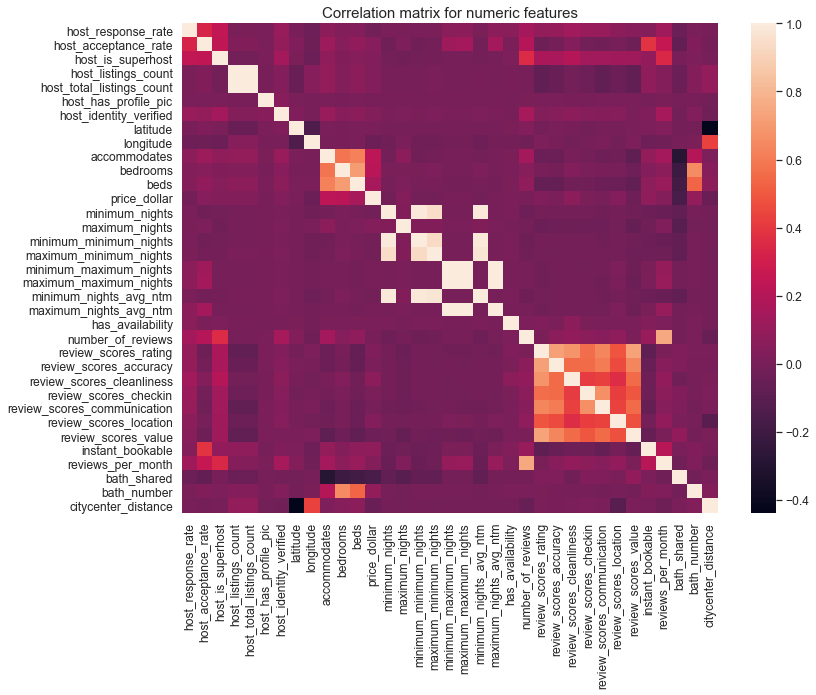

In [15]:
fig = plt.gcf()
fig.set_size_inches(12, 9)
sns.set_theme(style="whitegrid")
sns.set(font_scale=1.1)

ax = sns.heatmap(listings_drop.select_dtypes(float).corr(), annot_kws={"fontsize":15})
ax.set_title("Correlation matrix for numeric features", size=15);

## Question 1: How do superhosts compare to standard hosts?

### Where do (super-)hosts come from?

In [16]:
print("Number of NANs in \"host_is_superhost\" feature:", listings_drop["host_is_superhost"].isnull().sum())
print("Number of NANs in \"host_location_country\" feature:", listings_drop["host_location_country"].isnull().sum())

Number of NANs in "host_is_superhost" feature: 0
Number of NANs in "host_location_country" feature: 11


In [17]:
print("Number of superhosts:", listings_drop["host_is_superhost"].sum())

Number of superhosts: 3258.0


,host_location_country
host_location_country,
Germany,3095
United States,26
Switzerland,19


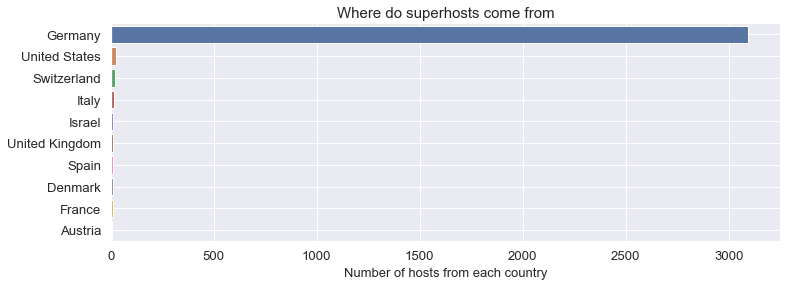

In [18]:
superhosts = listings_drop[listings_drop["host_is_superhost"] == True]
superhosts_country_top10 = pd.DataFrame(superhosts.groupby("host_location_country")["host_location_country"].count().sort_values(ascending=False)).iloc[:10]
display(superhosts_country_top10.head(3))

fig = plt.gcf()
fig.set_size_inches(12, 4)
sns.set_theme(style="whitegrid")
sns.set(font_scale=1.2)
ax = sns.barplot(x="host_location_country", y=superhosts_country_top10.index, data=superhosts_country_top10)
ax.set_title("Where do superhosts come from", size=15);
ax.set_xlabel("Number of hosts from each country", size=13);
ax.set_ylabel("");
ax.grid(True, axis="both");

,host_location_country
host_location_country,
Germany,15312
United States,186
United Kingdom,142


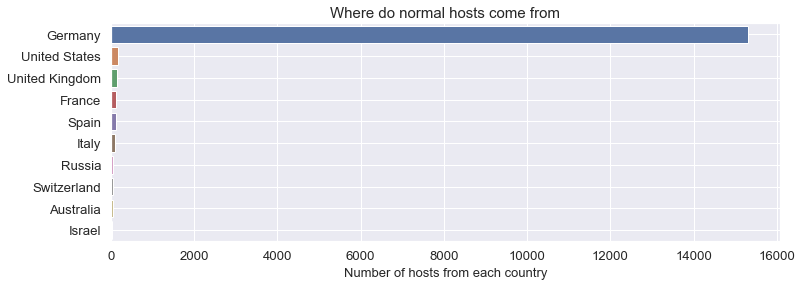

In [19]:
no_superhosts = listings_drop[listings_drop["host_is_superhost"] == False]
no_superhosts_country_top10 = pd.DataFrame(no_superhosts.groupby("host_location_country")["host_location_country"].count().sort_values(ascending=False)).iloc[:10]
display(no_superhosts_country_top10.head(3))

fig = plt.gcf()
fig.set_size_inches(12, 4)
sns.set_theme(style="whitegrid")
sns.set(font_scale=1.2)
ax = sns.barplot(x="host_location_country", y=no_superhosts_country_top10.index, data=no_superhosts_country_top10)
ax.set_title("Where do normal hosts come from", size=15);
ax.set_xlabel("Number of hosts from each country", size=13);
ax.set_ylabel("");
ax.grid(True, axis="both");

Both superhosts and normal hosts come mainly from Germany, while only a small percentage is from other countries like the United States.

### Are superhosts long term users?

In [20]:
print("Number of NANs in \"host_since_year\" feature:", listings_drop["host_since_year"].isnull().sum())

Number of NANs in "host_since_year" feature: 0


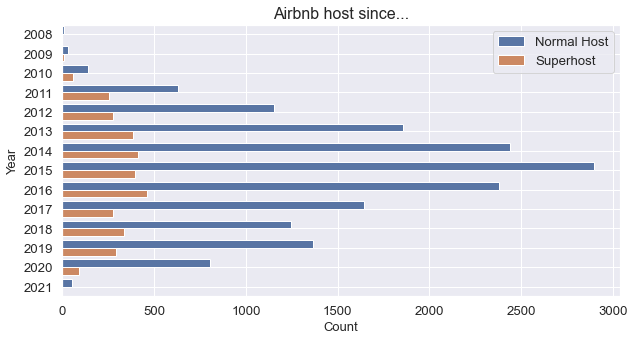

In [21]:
fig = plt.gcf()
fig.set_size_inches(10, 5)
sns.set_theme(style="whitegrid")
sns.set(font_scale=1.2)
years = ["2008", "2009", "2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020", "2021"]
ax = sns.countplot(data=listings_drop, y="host_since_year", hue="host_is_superhost", order=years)
ax.set_title("Airbnb host since...", size=16);
ax.set_xlabel("Count", size=13);
ax.set_ylabel("Year", size=13);
ax.legend(["Normal Host", "Superhost"]);
ax.grid(True, axis="both");

There is no clear difference visible from the data, that would indicate current superhosts being longer Airbnb users.

### Do superhosts get better reviews?

In [22]:
review_columns = ["host_is_superhost", "review_scores_rating", "review_scores_accuracy", "review_scores_cleanliness", "review_scores_checkin", "review_scores_communication", "review_scores_location", "review_scores_value"]
review_columns_short = ["host_is_superhost", "rating", "accuracy", "cleanliness", "checkin", "comm.", "location", "value"]

print("Number of NANs in \"review_...\" feature:")
display(listings_drop[review_columns].isnull().sum())

review_no_nan = listings_drop[review_columns].dropna(subset=review_columns, how="any", axis=0)
review_no_nan.columns = review_columns_short

display(review_no_nan.head(2))

review_no_nan_superhost = review_no_nan[review_no_nan["host_is_superhost"] == True]
review_no_nan_no_superhost = review_no_nan[review_no_nan["host_is_superhost"] == False]
display(review_no_nan_superhost.mean())
display(review_no_nan_no_superhost.mean())

Number of NANs in "review_..." feature:


host_is_superhost                 0
review_scores_rating           4479
review_scores_accuracy         4498
review_scores_cleanliness      4497
review_scores_checkin          4510
review_scores_communication    4499
review_scores_location         4508
review_scores_value            4511
dtype: int64

,host_is_superhost,rating,accuracy,cleanliness,checkin,comm.,location,value
0,0.0,93.0,10.0,9.0,10.0,10.0,10.0,9.0
1,0.0,93.0,9.0,9.0,9.0,9.0,10.0,9.0


host_is_superhost     1.000000
rating               97.231922
accuracy              9.923127
cleanliness           9.748534
checkin               9.931270
comm.                 9.938762
location              9.802280
value                 9.622150
dtype: float64

host_is_superhost     0.000000
rating               93.854905
accuracy              9.602775
cleanliness           9.222511
checkin               9.678812
comm.                 9.680110
location              9.560497
value                 9.331981
dtype: float64

C:\Program Files\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3417: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resultiing Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Program Files\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3417: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resultiing Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  exec(code_obj, self.user_global_ns, self.user_ns)


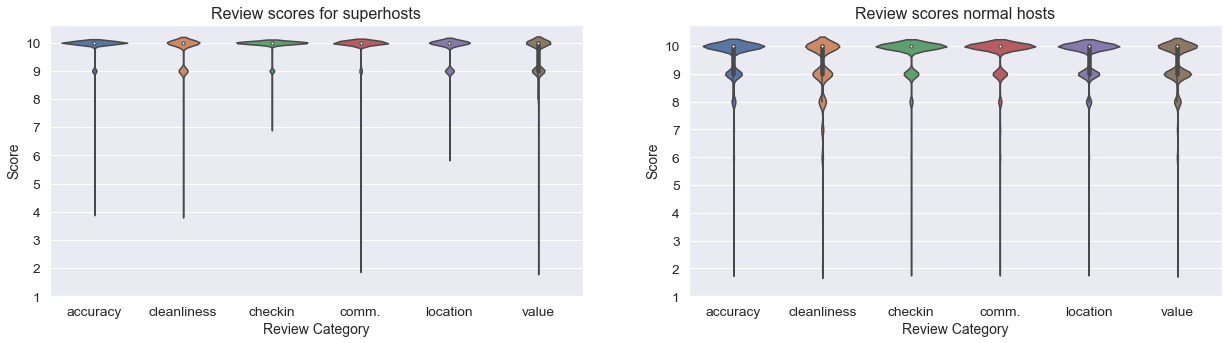

In [23]:
plt.figure(figsize=(21,5))
fig = plt.gcf()
sns.set_theme(style="whitegrid")
sns.set(font_scale=1.25)

# superhosts
plt.subplot(1, 2, 1)
ax = sns.violinplot(data=pd.melt(review_no_nan_superhost[review_columns_short[2:]]), x="variable", y="value")
ax.set_title("Review scores for superhosts", size=16);
ax.set_xlabel("Review Category", size=14);
ax.set_ylabel("Score", size=14);
ax.set(yticks=range(1,11));
# normal hosts
plt.subplot(1, 2, 2)
ax = sns.violinplot(data=pd.melt(review_no_nan_no_superhost[review_columns_short[2:]]), x="variable", y="value")
ax.set_title("Review scores normal hosts", size=16);
ax.set_xlabel("Review Category", size=14);
ax.set_ylabel("Score", size=14);
ax.set(yticks=range(1,11));

Super Hosts Rating:	Median: 98.0 / Mean: 97.23192182410423
Normal Hosts Rating:	Median: 98.0 / Mean: 93.85490546133246


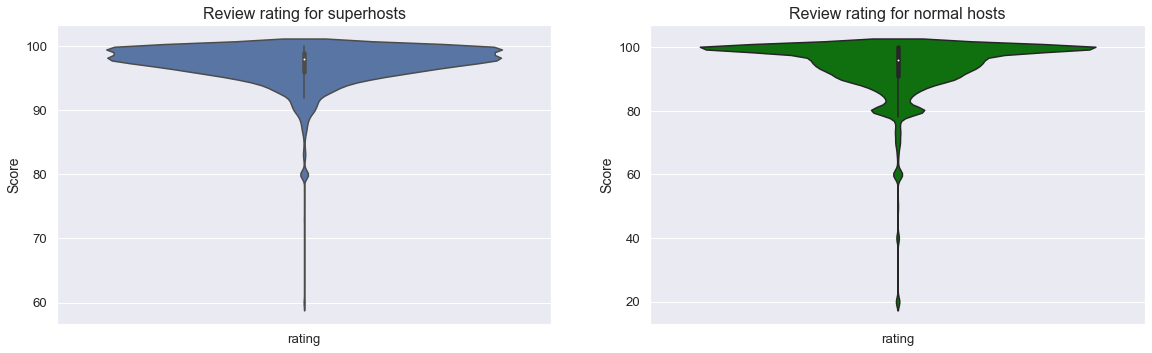

In [24]:
plt.figure(figsize=(19.5,5.5))
fig = plt.gcf()
sns.set_theme(style="whitegrid")
sns.set(font_scale=1.2)

# superhosts
print("Super Hosts Rating:\tMedian: {} / Mean: {}".format(review_no_nan_superhost["rating"].median(), review_no_nan_superhost["rating"].mean()))
plt.subplot(1, 2, 1)
ax = sns.violinplot(data=pd.melt(review_no_nan_superhost[review_columns_short[1:2]]), x="variable", y="value")
ax.set_title("Review rating for superhosts", size=16);
ax.set_xlabel("", size=14);
ax.set_ylabel("Score", size=14);
# normal hosts
print("Normal Hosts Rating:\tMedian: {} / Mean: {}".format(review_no_nan_superhost["rating"].median(), review_no_nan_no_superhost["rating"].mean()))
plt.subplot(1, 2, 2)
ax = sns.violinplot(data=pd.melt(review_no_nan_no_superhost[review_columns_short[1:2]]), x="variable", y="value", color="green")
ax.set_title("Review rating for normal hosts", size=16);
ax.set_xlabel("", size=14);
ax.set_ylabel("Score", size=14);

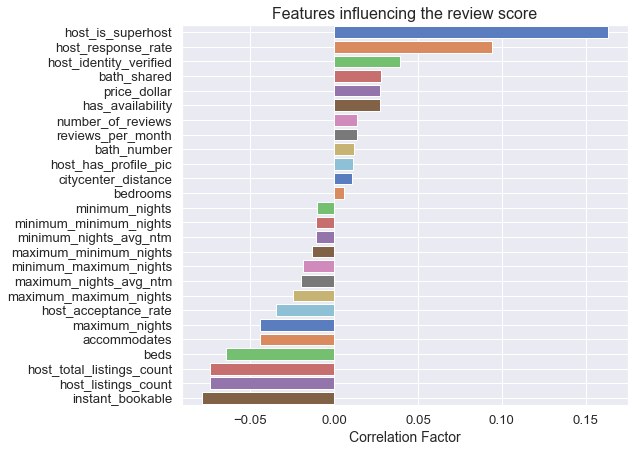

In [25]:
# get correlation factors for numeric features influencing the review score
review_corr = listings_drop.select_dtypes(float).corr()["review_scores_rating"].sort_values(ascending=False)[1:] # [1:] to exclude price:price corr value (=1)
# drop nonrelevant features
review_corr = review_corr.drop(["longitude", "latitude", "review_scores_value", "review_scores_accuracy", 
                              "review_scores_cleanliness", "review_scores_communication", "review_scores_checkin", "review_scores_location"])
#display(review_corr)

# plot correlation factors
fig = plt.gcf()
fig.set_size_inches(8, 7)
sns.set_theme(style="whitegrid")
sns.set(font_scale=1.2)
ax = sns.barplot(x=review_corr.values, y=review_corr.index, palette="muted")
ax.set_title("Features influencing the review score", size=16);
ax.set_xlabel("Correlation Factor", size=14);
ax.grid(True, axis="both");

Although overall the ratings are quite excellent, there are some differences between superhosts and normal hosts. As might be expected superhost probably have more experience and thus get slightly better review from their guests which is visible in the mean overall rating of 97.2 vs. 93.8 for normal hosts. Interestingly this differentiation is especially the case in the "checkin" and "location" category with less outliers in the lower score ranges for superhosts. So maybe superhosts have a more professional way to get their guests checked in than someone who is renting his or her appartment out just from time to time. Also the location of superhosts seems to be more attractive. Again superhosts may be looking for especially beautiful places to rent, while normal hosts probably often just share their own home.

### How many listings do superhosts have?

In [26]:
print("Number of listings:\t", len(listings_drop["id"].unique()))
print("Number of hosts:\t", len(listings_drop["host_id"].unique()))

Number of listings:	 19910
Number of hosts:	 15930


(50, 1)

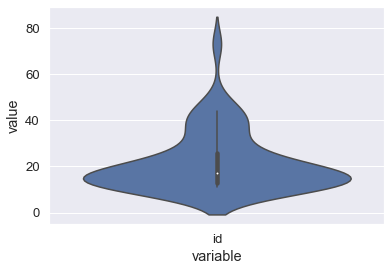

In [27]:
listings_per_host = pd.DataFrame(listings_drop.groupby("host_id")["id"].count()) #.sort_values(by="id", ascending=False)#.hist();
listings_per_host_greater1 = listings_per_host[listings_per_host["id"] > 10]
display(listings_per_host_greater1.sort_values(by="id", ascending=False).shape)

ax = sns.violinplot(data=pd.melt(pd.DataFrame(listings_per_host_greater1)), x="variable", y="value")

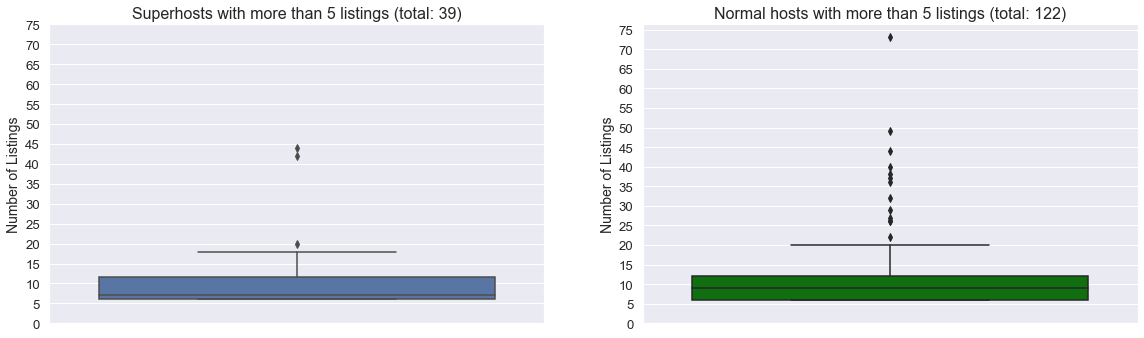

In [28]:
listings_per_superhost = pd.DataFrame(superhosts.groupby("host_id")["id"].count()) #.sort_values(by="id", ascending=False)#.hist();
listings_per_superhost_greater1 = listings_per_superhost[listings_per_superhost["id"] > 5]

listings_per_no_superhost = pd.DataFrame(no_superhosts.groupby("host_id")["id"].count()) #.sort_values(by="id", ascending=False)#.hist();
listings_per_no_superhost_greater1 = listings_per_no_superhost[listings_per_no_superhost["id"] > 5]

plt.figure(figsize=(19.5,5.5))
fig = plt.gcf()
sns.set_theme(style="whitegrid")
sns.set(font_scale=1.2)

# superhosts
plt.subplot(1, 2, 1)
ax = sns.boxplot(data=pd.melt(pd.DataFrame(listings_per_superhost_greater1)), x="variable", y="value")
ax.set_title(f"Superhosts with more than 5 listings (total: {listings_per_superhost_greater1.shape[0]})", size=16);
ax.set_xlabel("", size=13);
ax.set_ylabel("Number of Listings", size=14);
ax.set(yticks=range(0,80, 5));
ax.set_xticklabels("");
# normal hosts
plt.subplot(1, 2, 2)
ax = sns.boxplot(data=pd.melt(pd.DataFrame(listings_per_no_superhost_greater1)), x="variable", y="value", color="green")
ax.set_title(f"Normal hosts with more than 5 listings (total: {listings_per_no_superhost_greater1.shape[0]})", size=16);
ax.set_xlabel("", size=13);
ax.set_ylabel("Number of Listings", size=14);
ax.set(yticks=range(0,80, 5));
ax.set_xticklabels("");

Being it superhosts or not, there are hosts with way over 20 listings in the current dataset. But contrary to what one could expect, the hosts with the most listings are no superhosts. While superhosts have at maximum 44 listings, there are some non superhosts with up to 73 listings.

### Are superhosts mostly located near the city centre?

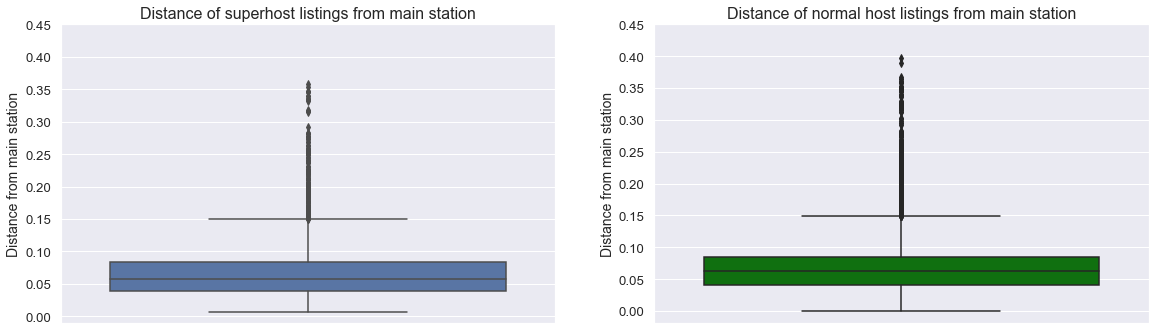

In [29]:
plt.figure(figsize=(19.5,5.5))
fig = plt.gcf()
sns.set_theme(style="whitegrid")
sns.set(font_scale=1.2)

# superhosts
plt.subplot(1, 2, 1)
ax = sns.boxplot(data=pd.melt(pd.DataFrame(superhosts["citycenter_distance"])), x="variable", y="value")
ax.set_title("Distance of superhost listings from main station", size=16);
ax.set_xlabel("", size=14);
ax.set_ylabel("Distance from main station", size=14);
ax.set(yticks=np.arange(0,0.5, 0.05));
ax.set_xticklabels("");
# normal hosts
plt.subplot(1, 2, 2)
ax = sns.boxplot(data=pd.melt(pd.DataFrame(no_superhosts["citycenter_distance"])), x="variable", y="value", color="green")
ax.set_title("Distance of normal host listings from main station", size=16);
ax.set_xlabel("", size=14);
ax.set_ylabel("Distance from main station", size=14);
ax.set(yticks=np.arange(0,0.5, 0.05));
ax.set_xticklabels("");

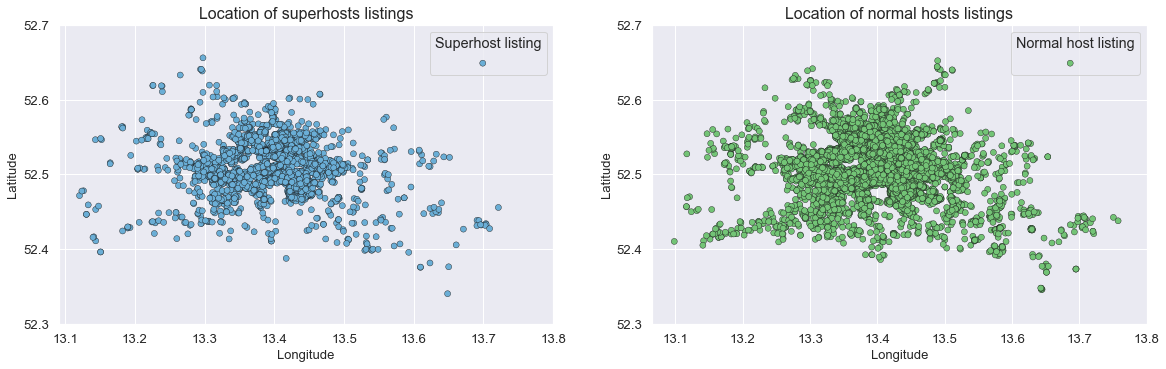

In [30]:
# create location / listing scatterplot
plt.figure(figsize=(19.5,5.5))
fig = plt.gcf()
sns.set_theme(style="whitegrid")
sns.set(font_scale=1.2)

loc_superhost = listings_drop[listings_drop["host_is_superhost"] == 1][["longitude", "latitude", "host_is_superhost"]]
loc_normalhost = listings_drop[listings_drop["host_is_superhost"] == 0][["longitude", "latitude", "host_is_superhost"]]
# location of superhosts
plt.subplot(1, 2, 1)
ax = sns.scatterplot(data=loc_superhost, x="longitude", y="latitude", hue="host_is_superhost", palette="Blues", edgecolor="k", linewidth=.4)
ax.set_title("Location of superhosts listings", size=16);
ax.set_xlabel("Longitude", size=13);
ax.set_ylabel("Latitude", size=13);
ax.legend(title="Superhost listing", labels=[""]);
ax.set(xticks=np.arange(13.1,13.8, 0.1));
ax.set(yticks=np.arange(52.3,52.7, 0.1));
# location of normal hosts
plt.subplot(1, 2, 2)
ax = sns.scatterplot(data=loc_normalhost, x="longitude", y="latitude", hue="host_is_superhost", palette="Greens", edgecolor="k", linewidth=.4)
ax.set_title("Location of normal hosts listings", size=16);
ax.set_xlabel("Longitude", size=13);
ax.set_ylabel("Latitude", size=13);
ax.legend(title="Normal host listing", labels=[""]);
ax.set(xticks=np.arange(13.1,13.8, 0.1));
ax.set(yticks=np.arange(52.3,52.7, 0.1));

There is also not a very clear distinction between the locations of superhost listings vs. the locations of listings from normal hosts.

## Question 2: How does the listing location influence the price?

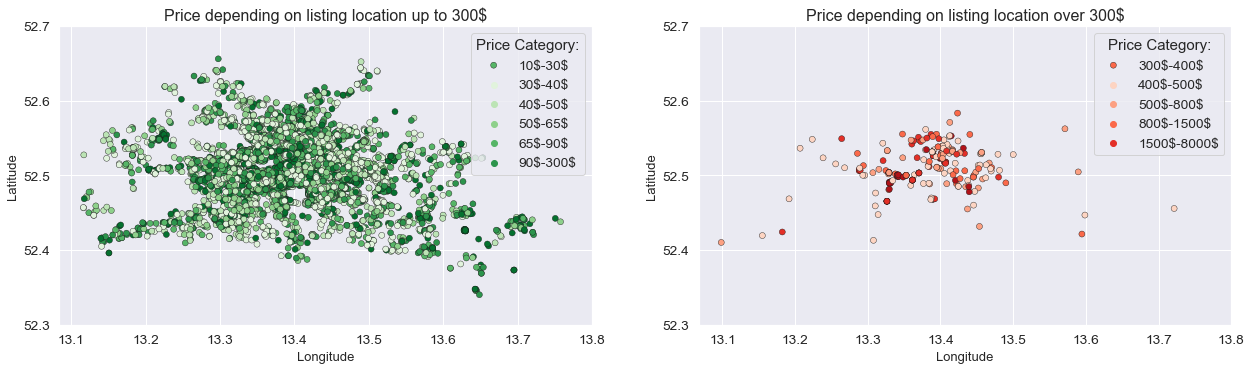

In [31]:
# create price bins to plot in scatterplot
price_low = 10
price_mid = 300
price_high = 8000
# create low price range bins
price_select_low = listings_drop[(listings_drop.price_dollar <= price_mid) & (listings_drop.price_dollar > price_low)]
price_select_low_cut, bins_low = pd.qcut(listings_drop[(listings_drop.price_dollar <= price_mid) & (listings_drop.price_dollar >= price_low)]["price_dollar"], q=6, precision=0, retbins=True)
leg_low = []
for i in range(len(bins_low)-1):
    leg_low.append(str(int(bins_low[i]))+"\$-"+str(int(bins_low[i+1]))+"\$")
# create high price range bins
price_select_high = listings_drop[(listings_drop.price_dollar <= price_high) & (listings_drop.price_dollar > price_mid)]
cut_bins = [300, 400, 500, 800, 1500, 8000]
price_select_high_cut, bins_high = pd.cut(listings_drop[(listings_drop.price_dollar <= price_high) & (listings_drop.price_dollar > price_mid)]["price_dollar"], bins=cut_bins, precision=0, retbins=True)
leg_high = []
for i in range(len(bins_high)-1):
    leg_high.append(str(int(bins_high[i]))+"\$-"+str(int(bins_high[i+1]))+"\$")
    
# create location / price scatterplot
plt.figure(figsize=(21,5.5))
fig = plt.gcf()
sns.set_theme(style="whitegrid")
sns.set(font_scale=1.25)

# up to 300$
plt.subplot(1, 2, 1)
ax = sns.scatterplot(data=price_select_low, x="longitude", y="latitude", hue=price_select_low_cut, palette="Greens", edgecolor="k", linewidth=.4)
ax.set_title("Price depending on listing location up to 300$", size=16);
ax.set_xlabel("Longitude", size=13);
ax.set_ylabel("Latitude", size=13);
ax.legend(title="Price Category:", labels=leg_low);
ax.set(xticks=np.arange(13.1,13.8, 0.1));
ax.set(yticks=np.arange(52.3,52.7, 0.1));
# above 300$
plt.subplot(1, 2, 2)
ax = sns.scatterplot(data=price_select_high, x="longitude", y="latitude", hue=price_select_high_cut, palette="Reds", edgecolor="k", linewidth=.4)
ax.set_title("Price depending on listing location over 300$", size=16);
ax.set_xlabel("Longitude", size=13);
ax.set_ylabel("Latitude", size=13);
ax.legend(title="Price Category:", labels=leg_high);
ax.set(xticks=np.arange(13.1,13.8, 0.1));
ax.set(yticks=np.arange(52.3,52.7, 0.1));

Looking at the price distribution across the city, the first thing that can be observed is a large spread in prices, ranging from around 10\\$ to 8000\\$.
For that reason the data has been split in tho groups, up to and over 300\\$. From those two datasets the plots show a rather uniform distribution on the 10-300\\$ range across the city. The dataset for prices over 300\\$ however shows, that those listings are more or less crowded in the city center region.

## Question 3: What other factors influence the price?

In [32]:
display(list(listings_drop["room_type"].unique()))

['Entire home/apt', 'Private room', 'Shared room', 'Hotel room']

In [33]:
# encode room_type
room_type_num = lambda x: 0. if x == "Shared room" else ( 1. if x == "Private room" else ( 2. if x == "Hotel room" else 3. ))
listings_drop["room_type_num"] = listings_drop["room_type"].apply(room_type_num)

accommodates                   0.230104
bedrooms                       0.216858
room_type_num                  0.163386
beds                           0.153666
bath_number                    0.093258
instant_bookable               0.079059
review_scores_cleanliness      0.069774
host_acceptance_rate           0.049349
maximum_nights                 0.044468
reviews_per_month              0.041106
review_scores_location         0.041041
host_identity_verified         0.039123
host_is_superhost              0.037434
host_total_listings_count      0.034267
host_listings_count            0.034267
review_scores_rating           0.027206
review_scores_checkin          0.012107
has_availability               0.010560
review_scores_accuracy         0.007343
number_of_reviews              0.005355
host_has_profile_pic           0.004844
maximum_maximum_nights         0.002967
maximum_nights_avg_ntm         0.002967
minimum_maximum_nights         0.002966
review_scores_communication   -0.000113


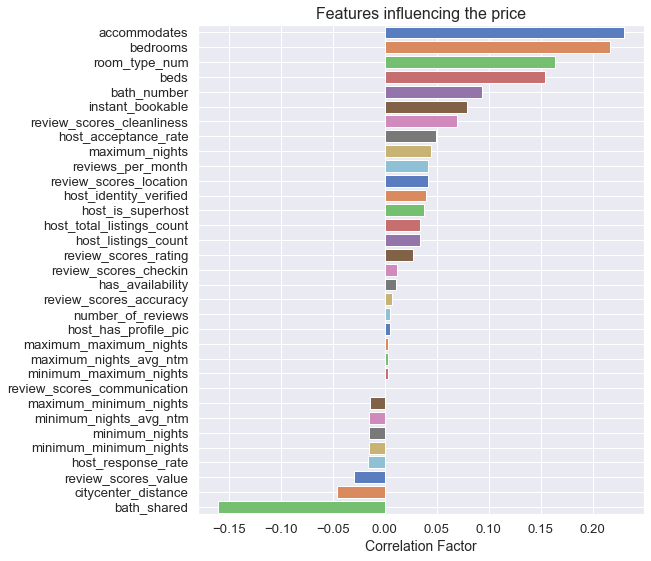

In [34]:
# get correlation factors for numeric features influencing the price
price_corr = listings_drop.select_dtypes(float).corr()["price_dollar"].sort_values(ascending=False)[1:] # [1:] to exclude price:price corr value (=1)
# drop nonrelevant features
price_corr = price_corr.drop(["longitude", "latitude"])
display(price_corr)

# plot correlation factors
fig = plt.gcf()
fig.set_size_inches(8, 9)
sns.set_theme(style="whitegrid")
sns.set(font_scale=1.2)
ax = sns.barplot(x=price_corr.values, y=price_corr.index, palette="muted")
ax.set_title("Features influencing the price", size=16);
ax.set_xlabel("Correlation Factor", size=14);
ax.grid(True, axis="both");

The most important features correlating to the listing price are clearly linked to the size of the accomodation. So the number of people that can be accomodated, the number of bedrooms, beds and bathrooms are obviously good indicators of the price. 

It can also be noticed, that everything connected to sharing the space, being it the bath or the room itself, has a clear negative correlation to the price.

## 03. Data Preparation and 04. Data Modelling

### Predicting Airbnb Prices

In [35]:
# prepare data for model training
def prepare_data(data, price_limits=10000):
    """
    Function to prepare and split the data for use with ML models
    INPUT
    data = input dataset as pd.DataFrame
    price_limits = parameter for limiting the dataset to a price range below that limit
    OUTPUT
    two lists of train/test datasets with focus on datapoints and featues
    """
    # drop NANs and use only float columns
    model_data_col_clean = data[data.columns[data.notnull().all()]].select_dtypes(float)
    model_data_col_clean = model_data_col_clean[model_data_col_clean["price_dollar"] < price_limits]
    print("Size of high datapoints dataset:", model_data_col_clean.shape)
    model_data_row_clean = data.select_dtypes(float).dropna(axis=0)
    model_data_row_clean = model_data_row_clean[model_data_row_clean["price_dollar"] < price_limits]
    print("Size of high feature dataset:", model_data_row_clean.shape)

    # high datapoint dataset
    X_d = model_data_col_clean.drop(columns=["price_dollar"])
    y_d = model_data_col_clean["price_dollar"]
    X_d_train, X_d_test, y_d_train, y_d_test = train_test_split(X_d, y_d, test_size=0.3, random_state=23)

    # high feature dataset
    X_f = model_data_row_clean.drop(columns=["price_dollar"])
    y_f = model_data_row_clean["price_dollar"]
    X_f_train, X_f_test, y_f_train, y_f_test = train_test_split(X_f, y_f, test_size=0.3, random_state=23)
    
    return [X_d_train, X_d_test, y_d_train, y_d_test], [X_f_train, X_f_test, y_f_train, y_f_test]

In [36]:
# train models on prepared data
def train_eval_models(modellist, data, sort_by="R2", random_state=23):
    """
    Function to evaluate sklearn regression models
    INPUT
    modellist = list of sklearn models e.g. [DecisionTreeRegressor, AdaBoostRegressor]
    data = list of train_test data e.g. [X_train, X_test, y_train, y_test]
    sort_by = metric by which ouput is sorted
    random_state = random_state for model initialization
    OUTPUT
    best trained model
    """
    model_eval = pd.DataFrame(columns=["Model", "R2", "MSE", "RMSE", "MAE"])
    for mod in modellist:
        if mod == LinearRegression:
            model = mod(fit_intercept=True, normalize=True)
        else:
            model = mod(random_state=random_state)
        print(f"Fitting {model}")
        model.fit(data[0], data[2])
        pred = model.predict(data[1])
        metrics = pd.DataFrame([[model, r2_score(data[3], pred), mean_squared_error(data[3], pred),
                                mean_squared_error(data[3], pred, squared=False), mean_absolute_error(data[3], pred)]], columns=model_eval.columns)
        model_eval = model_eval.append(metrics, ignore_index=True).round(2) 
    
    if len(modellist) > 1:
        model_eval.sort_values(by=sort_by, inplace=True, ascending=False, ignore_index=True)
    
    best_model = model_eval["Model"][0]
    model_eval["Model"] = model_eval["Model"].apply(lambda x: str(x))
    display(model_eval)
    
    return best_model

In [37]:
# plot feature importance / coefficients
def feat_importance(model, cols):
    """
    Function to extract information on feature importances or coefficients of given model
    INPUT
    model = trained sklearn model (linear regression or tree regression)
    cols = column names of used training data
    """
    try:
        feat_df = pd.DataFrame(pd.Series(model.feature_importances_, dtype=float, name="feature_importance"))
    except:
        feat_df = pd.DataFrame(pd.Series(model.coef_, dtype=float, name="feature_importance"))
        
    feat_df["feature"] = cols
    feat_df_top5 = feat_df.sort_values(by="feature_importance", ascending=False).head(5)
    #display(feat_df_top5)
    
    fig = plt.gcf()
    fig.set_size_inches(7, 2.5)
    sns.set_theme(style="whitegrid")
    sns.set(font_scale=1.2)
    ax = sns.barplot(x=feat_df_top5.feature_importance, y=feat_df_top5.feature, palette="muted")
    ax.set_title("Features influencing the modelled price", size=16);
    ax.set_xlabel("Correlation Factor / Feature Importance", size=14);
    ax.grid(True, axis="both");

Since there are some columns / rows with missing data, two float-type datasets are prepared for model comparison. One dataset where columns with missing values have been removed and thus less features to learn (denoted by "_d"), and one dataset where the rows with missing values have been dropped resulting in more features but fewer datapoints to learn on (denoted by "_f").

In [38]:
# list of models to evaluate on data
models_to_eval = [LinearRegression, DecisionTreeRegressor, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, RandomForestRegressor]

#### Modelling on whole price range

In [39]:
data_all_d, data_all_f = prepare_data(listings_drop, 10000)

Size of high datapoints dataset: (19910, 16)
Size of high feature dataset: (5475, 36)


In [40]:
# train and evalutate models with high feature dataset with whole price range
mod_all_f = train_eval_models(models_to_eval, data_all_f)
# train and evalutate models with high datapoints dataset with whole price range
mod_all_d = train_eval_models(models_to_eval, data_all_d)

Fitting LinearRegression(normalize=True)
Fitting DecisionTreeRegressor(random_state=23)
Fitting AdaBoostRegressor(random_state=23)
Fitting BaggingRegressor(random_state=23)
Fitting GradientBoostingRegressor(random_state=23)
Fitting RandomForestRegressor(random_state=23)


,Model,R2,MSE,RMSE,MAE
0,RandomForestRegressor(random_state=23),0.57,5143.25,71.72,25.71
1,BaggingRegressor(random_state=23),0.56,5280.69,72.67,27.61
2,GradientBoostingRegressor(random_state=23),0.37,7559.37,86.94,29.79
3,DecisionTreeRegressor(random_state=23),0.33,8044.60,89.69,36.01
4,LinearRegression(normalize=True),0.18,9780.61,98.90,36.27
5,AdaBoostRegressor(random_state=23),-0.18,14148.36,118.95,85.72


Fitting LinearRegression(normalize=True)
Fitting DecisionTreeRegressor(random_state=23)
Fitting AdaBoostRegressor(random_state=23)
Fitting BaggingRegressor(random_state=23)
Fitting GradientBoostingRegressor(random_state=23)
Fitting RandomForestRegressor(random_state=23)


,Model,R2,MSE,RMSE,MAE
0,GradientBoostingRegressor(random_state=23),0.22,10977.49,104.77,30.30
1,RandomForestRegressor(random_state=23),0.16,11704.52,108.19,29.02
2,AdaBoostRegressor(random_state=23),0.13,12206.62,110.48,38.73
3,LinearRegression(normalize=True),0.08,12845.56,113.34,33.23
4,BaggingRegressor(random_state=23),-0.05,14715.28,121.31,31.01
5,DecisionTreeRegressor(random_state=23),-1.03,28452.04,168.68,39.15


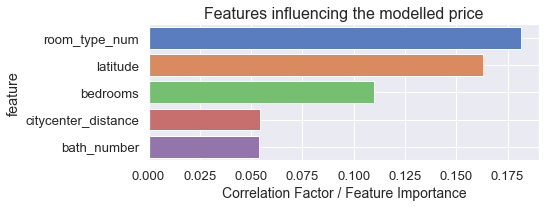

In [41]:
# model features on dataset with more features / less data, with whole price range
feat_importance(mod_all_f, data_all_f[0].columns)

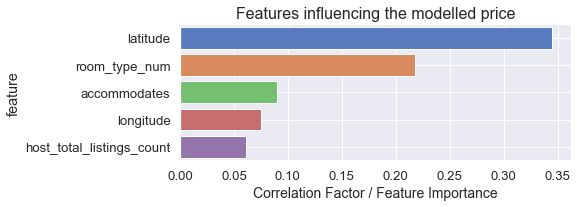

In [42]:
# model features on dataset with less features / more data, with whole price range
feat_importance(mod_all_d, data_all_d[0].columns)

#### Modelling on price range < 300\\$

In [43]:
data_300_d, data_300_f = prepare_data(listings_drop, 300)

Size of high datapoints dataset: (19658, 16)
Size of high feature dataset: (5376, 36)


In [44]:
# evalutate models with high feature dataset, with price range < 300$
mod_300_f = train_eval_models(models_to_eval, data_300_f)
# evalutate models with high datapoints dataset, with price range < 300$
mod_300_d = train_eval_models(models_to_eval, data_300_d)

Fitting LinearRegression(normalize=True)
Fitting DecisionTreeRegressor(random_state=23)
Fitting AdaBoostRegressor(random_state=23)
Fitting BaggingRegressor(random_state=23)
Fitting GradientBoostingRegressor(random_state=23)
Fitting RandomForestRegressor(random_state=23)


,Model,R2,MSE,RMSE,MAE
0,RandomForestRegressor(random_state=23),0.63,896.47,29.94,20.12
1,GradientBoostingRegressor(random_state=23),0.62,920.81,30.34,20.73
2,BaggingRegressor(random_state=23),0.57,1038.83,32.23,21.66
3,LinearRegression(normalize=True),0.51,1173.78,34.26,23.60
4,DecisionTreeRegressor(random_state=23),0.29,1706.14,41.31,27.19
5,AdaBoostRegressor(random_state=23),0.28,1730.64,41.60,34.93


Fitting LinearRegression(normalize=True)
Fitting DecisionTreeRegressor(random_state=23)
Fitting AdaBoostRegressor(random_state=23)
Fitting BaggingRegressor(random_state=23)
Fitting GradientBoostingRegressor(random_state=23)
Fitting RandomForestRegressor(random_state=23)


,Model,R2,MSE,RMSE,MAE
0,RandomForestRegressor(random_state=23),0.50,870.88,29.51,19.55
1,GradientBoostingRegressor(random_state=23),0.48,911.47,30.19,20.08
2,BaggingRegressor(random_state=23),0.46,940.72,30.67,20.42
3,LinearRegression(normalize=True),0.40,1046.13,32.34,21.67
4,AdaBoostRegressor(random_state=23),0.33,1172.06,34.24,25.31
5,DecisionTreeRegressor(random_state=23),0.06,1647.53,40.59,26.64


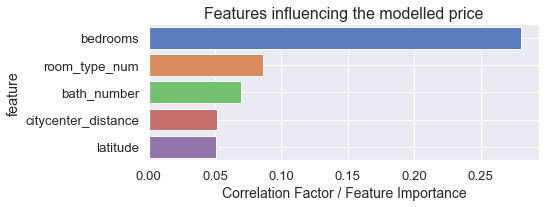

In [45]:
# model features on dataset with more features / less data, prices < 300$
feat_importance(mod_300_f, data_300_f[0].columns)

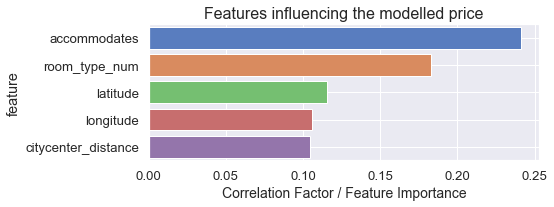

In [46]:
# model features on dataset with less features / more data, prices < 300$
feat_importance(mod_300_d, data_300_d[0].columns)

## 05. Evaluation and Results

The results using the two different partial datasets for modelling seems surprising. Six different models were evaluated:
1. LinearRegression
2. DecisionTreeRegressor
3. AdaBoostRegressor 
4. BaggingRegressor 
5. GradientBoostingRegressor 
6. RandomForestRegressor

All the evaluated models performed much better on the dataset with more features, but less datapoints to train on. So the columns with lots of missing values are actually quite important to predict the price of an Airbnb listing.
Out of the six models the RandomForestRegressor worked best with an R2 score of 0.57.

Since the data has some outliers way over 500\\$ (as shown in _03. Data Preparation_), a comparison between a dataset with the whole price range and a dataset with prices below 300\\$ was done.
With the sub 300\\$ dataset the difference between model results with the "more features" and "more datapoints" dataset becomes significantly smaller and all model evaluations get better when using the sub 300\\$ dataset. \
The RandomForestRegressor still wins the comparison with an R2 score of 0.63 and feature importances similar to those shown in the simple feature correlation in _03. Data Preparation_.

Other answers on the imposed questions from _01. Business Understanding_ are included in _03. Data Preparation_ along with the wrangling and understanding of the data. So here's a short summary:

1. How do superhosts compare to standard hosts?
    - Where do (super-)hosts come from?
        * Both superhosts and normal hosts come mainly from Germany, while only a small percentage is from other countries like the United States.
    - Are superhosts long term hosts (since 2008)?
        * There is no clear difference visible from the data, that would indicate current superhosts being longer Airbnb users.
    - Do superhosts get better reviews?
        * Superhosts get slightly better reviews from their guests which is visible in the mean overall rating of 97.2 vs. 93.8.
    - Are superhosts mostly located near the citycentre?
        * There is also not a very clear distinction between the locations of superhost listings vs. the locations of listings from normal hosts.
    - How many listings do superhosts have?
        * Contrary to what one could expect, the hosts with the most listings are no superhosts. While superhosts have at maximum 44 listings, there are some non superhosts with up to 73 listings.
2. How does the listing location influence the price?
    * The plots show a rather uniform distribution on the 10-300\\$ range across the city. For prices over 300\\$ however, those listings are more or less crowded in the city center region.
3. What factors influence the price?
    * The most important factors are related to the size of the accomodation. Strong negative correlation can be seen when it comes to sharing space.

## 06. Deployment

Deployment in the specific case of this project is adressed by publishing a summary article on the findings of this analysis in the form of a blog post.

The article can be found here: [www.medium.com](https://dscm.medium.com/airbnb-berlin-a-short-analysis-on-pricing-and-superhosts-cc1cea9efbb2)